In [10]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torchmetrics import StructuralSimilarityIndexMeasure
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import json
from tqdm import tqdm
from glob import glob
import sys
path = "/study/mrphys/skunkworks/kk/mriUnet"
sys.path.insert(0,path)
import unet
from torchvision import transforms
from torch.utils.data import Dataset
import h5py
from sklearn.model_selection import KFold as kf
import os
import nibabel as nib

T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
xPath = sorted(glob('/scratch/mrphys/denoised/denoised_*.h5'))
gtPath = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/C.h5'))

def slice2d(array, discardZero=False):
    '''
    slice a 4d array of shape (c-channel, n, n, n) where n in the cube length
    into 3d arrays slices of shape (c, n, n) per each 2d plane
    '''
    result = []
    c, w, h, d = array.shape
    assert (w==h)and(h==d)and(d==w), f"Array must be cubic, got: {w}x{h}x{d}"
    for i in range(w):
        result.append(array[:,i,:,:])
        result.append(array[:,:,i,:])
        result.append(array[:,:,:,i])
    return np.array(result)

def getComplexSlices(path, return_scale=False):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(6):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.max([np.abs(np.array(image['real'])).max(), np.abs(np.array(image['imag'])).max()])
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        imagesliceReal = slice2d(imagestackReal)
        imagesliceImag = slice2d(imagestackImag)
        
    if return_scale:
        return imagesliceReal+imagesliceImag*1j, normScale
    else:
        return imagesliceReal+imagesliceImag*1j
    
class T1Dataset(Dataset):
    
    def __init__(self, index, gt=False, norm_factor=1000):
    
        if gt:
            self.x_path = gtPath[index]
        else:
            self.x_path = xPath[index]  
        self.y_path = T1path[index]
        
        self.x = list(getComplexSlices(self.x_path))
        self.y = list(slice2d(np.transpose(nib.load(self.y_path).get_fdata()).reshape(1,256,256,256)/norm_factor))

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)
    
def predict(model, dataset, device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")):
    model.eval()
    model.to(device)
    X = []
    X0 = []
    Y = []
    Y0 = []
    Z = []
    Z0 = []
    for i, (pca, y) in tqdm(enumerate(dataset)):
        pca = torch.tensor(pca).to(device).unsqueeze(0)
        with torch.no_grad():
            p = torch.abs(model(pca)).cpu().numpy()
            if i%3==0:
                X.append(p)
                X0.append(np.expand_dims(y,0))
            elif i%3==1:
                Y.append(p)
                Y0.append(np.expand_dims(y,0))
            else:
                Z.append(p)
                Z0.append(np.expand_dims(y,0))
                
    pred = np.vstack(X).transpose(1,0,2,3), np.vstack(Y).transpose(1,2,0,3), np.vstack(Z).transpose(1,2,3,0)
    y = np.vstack(X0).transpose(1,0,2,3), np.vstack(Y0).transpose(1,2,0,3), np.vstack(Z0).transpose(1,2,3,0)
                   
    return pred, y

def get_prediction(idx, name='T1', fold=1, gt=False):
    
    name=f'{name}_{fold}'
    dataset = T1Dataset(idx, gt)
            
    order = ['separable convolution', 'relu']
    if 'bn' in name or 'GAN' in name:
        order.append('batch norm')
    
    mapper = unet.UNet(6,
            1,
            f_maps=32,
            layer_order=order,
            depth=3,
            layer_growth=2.0,
            residual=True,
            complex_input=True,
            complex_kernel=True,
            ndims=2,
            padding=1)
    mapper.load_state_dict(torch.load(f'/study/mrphys/skunkworks/kk/outputs/{name}/weights/{name}_LATEST.pth'))

    (X, Y, Z), (X0, Y0, Z0) = predict(mapper, dataset)
    
    return (X+Y+Z)/3, (X0+Y0+Z0)/3

In [8]:
kfsplitter = kf(n_splits=5, shuffle=True, random_state=69420)
for train_index, test_index in kfsplitter.split(T1path):
    print(test_index)

[ 4  7 13 16 20 21 24 31 37 40 42 56 61]
[ 3  5  8 25 26 35 43 47 49 51 60 62 63]
[ 6 12 17 18 19 28 32 34 36 45 48 50 58]
[ 0  1  2  9 11 14 23 27 29 33 39 52 54]
[10 15 22 30 38 41 44 46 53 55 57 59 64]


In [13]:
pred_denoised, y = get_prediction(4, name='T1_denoised_bn', gt=False)
pred_gan, y = get_prediction(4, name='T1_denoised_GAN', gt=False)
pred, y = get_prediction(4, name='T1', gt=True)

Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16)]


768it [00:11, 64.05it/s]


Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16)]


768it [00:09, 81.68it/s]


Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16)]


768it [00:07, 100.77it/s]


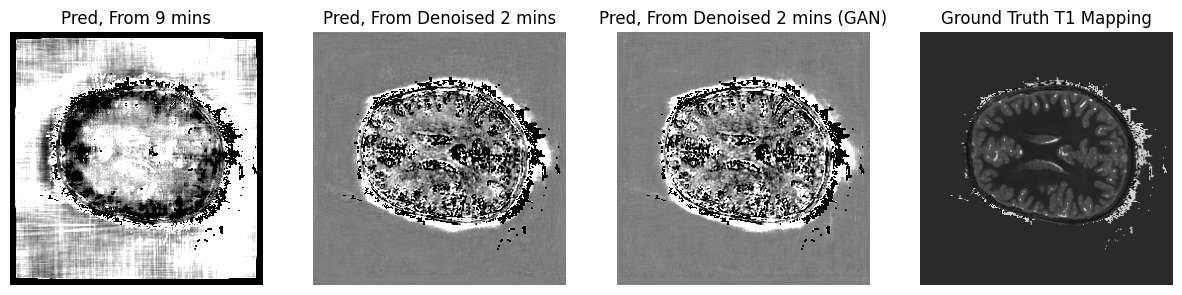

In [60]:
n = 150

fig, ax = plt.subplots(1,4,figsize=(15,5))
plt.gray()
ax[0].axis('off')
ax[0].imshow(pred[0,n]-y[0,n], vmin=-0.1, vmax=0.1)
ax[0].set_title("Pred, From 9 mins")
ax[1].axis('off')
ax[1].imshow(pred_denoised[0,n]-y[0,n], vmin=-0.1, vmax=0.1)
ax[1].set_title("Pred, From Denoised 2 mins")
ax[2].axis('off')
ax[2].imshow(pred_gan[0,n]-y[0,n], vmin=-0.1, vmax=0.1)
ax[2].set_title("Pred, From Denoised 2 mins (GAN)")
ax[3].axis('off')
ax[3].imshow(np.abs(y[0,n]), vmin=0, vmax=6)
ax[3].set_title("Ground Truth T1 Mapping")
plt.show()

In [15]:
masks = sorted(glob('/scratch/mrphys/masks_for_kk/*/processed_data/mpnrage_composite_bfc_tv.anat/FAST_OUTPUT/T1_fast_seg_resliced.nii.gz'))

In [30]:
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )
    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups, padding='same')
    
smoother = GaussianSmoothing(1, 10, 0.2, 3).cuda()

In [43]:
@torch.no_grad()
def smoothen(pred):
    e = smoother(torch.tensor(pred).float().cuda())
    return e.cpu().numpy()

In [45]:
#mask = nib.load(masks[4]).get_fdata()==3
mask = None

def get_error(mask, x_raw, y_raw):
    if mask==None:
        mask = np.ones(x_raw.shape)
    x = smoothen(x_raw)
    y = smoothen(y_raw)
    x = x*mask
    x = x[x!=0]
    y = y*mask
    y = y[y!=0]
    return (x-y)/y

print('9 mins Preformance')

mae = np.mean(get_error(mask, pred, y))*100
sd = np.std(get_error(mask, pred, y))*100
print(mae, sd, sep='\n')

print('2 mins Preformance')

mae = np.mean(get_error(mask, pred_denoised, y))*100
sd = np.std(get_error(mask, pred_denoised, y))*100
print(mae, sd, sep='\n')

print('GAN Preformance')

mae = np.mean(get_error(mask, pred_gan, y))*100
sd = np.std(get_error(mask, pred_gan, y))*100
print(mae, sd, sep='\n')

# goal -> within 2-5% (?) of 9 min GT (around 20 mae)
# compared with pca to t1

# This week

# evaluation - figure out where's wrong
# mean error in addition to MAE -> mean = bias, std = how far from truth
# Bland-Altmann spatial error
# maybe get T1 from denoised

9 mins Preformance
-0.29508519151010176
16.668843399166988
2 mins Preformance
-0.5003763251445579
12.196288011252578
GAN Preformance
-0.23193314065780316
12.346501688501073


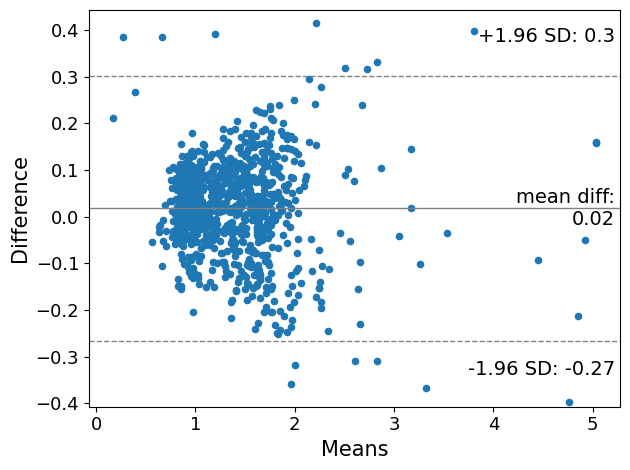

In [100]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import pandas as pd

e = pred*mask
f = y*mask
e = e[e!=0]
f = f[f!=0]

i = np.random.choice(np.arange(len(e)),1000,replace=False)

df = pd.DataFrame({'A': list(e[i]),
                   'B': list(f[i])})

#create Bland-Altman plot                  
fig, ax = plt.subplots(1)
sm.graphics.mean_diff_plot(df.A, df.B, ax = ax)

#display Bland-Altman plot
plt.show()

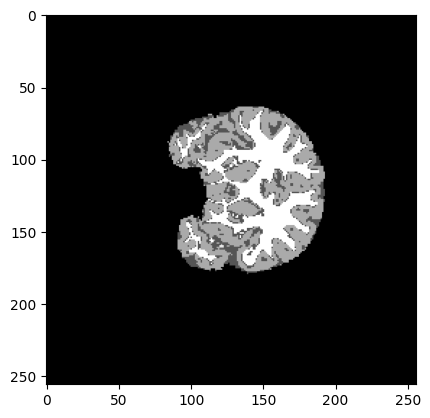

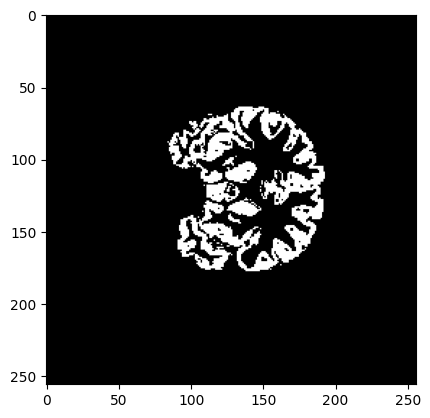

In [64]:
mask = nib.load(masks[4]).get_fdata()
plt.imshow(mask[100])
plt.show()
plt.imshow(mask[100]==2)

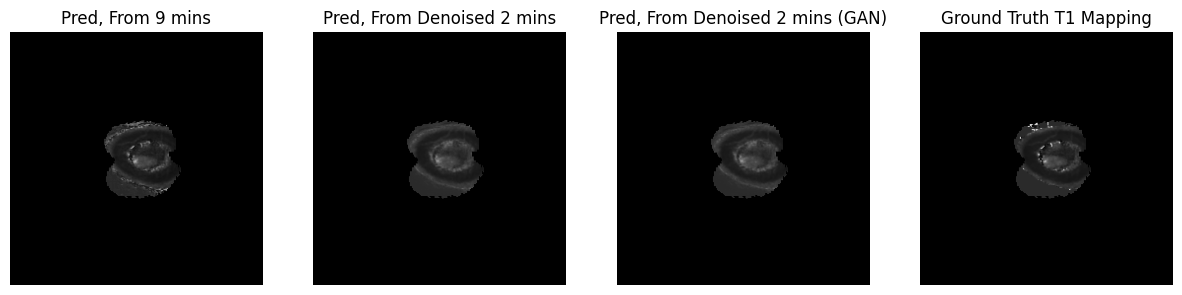

In [60]:
n = 200
mask = nib.load(masks[4]).get_fdata()!=0
fig, ax = plt.subplots(1,4,figsize=(15,5))
plt.gray()
ax[0].axis('off')
ax[0].imshow(np.abs(pred[0,n]*mask[n]), vmin=0, vmax=6)
ax[0].set_title("Pred, From 9 mins")
ax[1].axis('off')
ax[1].imshow(np.abs(pred_denoised[0,n]*mask[n]), vmin=0, vmax=6)
ax[1].set_title("Pred, From Denoised 2 mins")
ax[2].axis('off')
ax[2].imshow(np.abs(pred_denoised[0,n]*mask[n]), vmin=0, vmax=6)
ax[2].set_title("Pred, From Denoised 2 mins (GAN)")
ax[3].axis('off')
ax[3].imshow(np.abs(y[0,n]*mask[n]), vmin=0, vmax=6)
ax[3].set_title("Ground Truth T1 Mapping")
plt.show()

# Denoiser : 2 min PCA -> "9 min" PCA

# T1 Prediction : 9 min PCA -> 9 min T1 B1 and other params

# 2 min PCA -> "9 min" PCA -> 9 min T1 B1 and other params

# 2 min PCA -> 9 min T1 B1 and other params

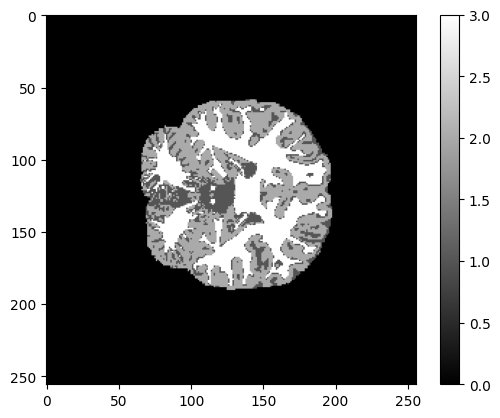

In [14]:
e = nib.load(masks[4]).get_fdata()
plt.imshow(e[150])
plt.colorbar()